In [13]:
import numpy as np
from scipy.stats import zscore
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


from scipy.stats import binned_statistic
from scipy.signal import find_peaks
from scipy.optimize import curve_fit  
from scipy.signal import convolve2d

import emd.sift as sift
import emd.spectra as spectra
import numpy as np
import pingouin as pg
import sails
import scipy.io as sio
import h5py
import os
import glob
import concurrent.futures
from skimage.feature import peak_local_max
from scipy.io import loadmat

In [14]:
#Functions:


# The get_rem_states function takes in an array of sleep states and the sample rate of the data.
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states and their start
    and end times from an array of sleep states.

    Parameters:
    - states (numpy.ndarray): One-dimensional array of sleep states.
    - sample_rate (int): The sample rate of the data.

    Returns:
    numpy.ndarray: An array containing start and end times of consecutive REM
    sleep states. Each row represents a pair of start and end times.

    Note:
    - Sleep states are represented numerically. In this function, REM sleep
      states are identified by the value 5 in the 'states' array.

    Example:
    ```python
    import numpy as np

    # Example usage:
    sleep_states = np.array([1, 2, 5, 5, 5, 3, 2, 5, 5, 4, 1])
    sample_rate = 2500  # Example sample rate in Hz
    rem_states_times = get_rem_states(sleep_states, sample_rate)
    print(rem_states_times)
    ```
    """
    try:
        # Ensure the sleep states array is one-dimensional.
        states = np.squeeze(states)
        # Find the indices where the sleep state is equal to 5, indicating REM sleep.
        rem_state_indices = np.where(states == 5)[0]
        
        # Check if there are no REM states. If so, return an empty array.
        if len(rem_state_indices) == 0:
            return np.array([])
        # Calculate the changes between consecutive REM state indices.
        rem_state_changes = np.diff(rem_state_indices)
        # Find the indices where consecutive REM states are not adjacent.
        split_indices = np.where(rem_state_changes != 1)[0] + 1
        # Add indices to split consecutive REM states, including the start and end indices.
        split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
        # Create an empty array to store start and end times of consecutive REM states.
        consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
        # Iterate through the split indices to extract start and end times.
        for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
            start = rem_state_indices[start] * int(sample_rate)
            end = rem_state_indices[end - 1] * int(sample_rate)
            consecutive_rem_states[i] = np.array([start, end])
        # Convert the array to a numpy array.
        ##consecutive_rem_states = np.array(consecutive_rem_states)
        # Create a mask to filter out consecutive REM states with negative duration.
        null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
        consecutive_rem_states = consecutive_rem_states[null_states_mask]
        # Return the array containing start and end times of consecutive REM states.
        return consecutive_rem_states
    # Handle the case where an IndexError occurs, typically due to an empty array.
    except IndexError as e:
        print(f"An IndexError occurred in get_rem_states: {e}")
        return np.array([])  # or any default value you want


# This function computes the Morlet wavelet transform of a given signal.
# It uses the SAILS library to perform the wavelet transform.
def morlet_wt(x, sample_rate, frequencies=np.arange(1, 200, 1), n=5, mode='complex'):
    """
    Compute the Morlet wavelet transform of a given signal using the SAILS library.

    Parameters:
    - x (numpy.ndarray): The input signal.
    - sample_rate (int): The rate at which the signal is sampled.
    - frequencies (numpy.ndarray, optional): The array of frequencies at which to compute the transform
      (default is from 1 to 200 Hz).
    - n (int, optional): The number of cycles in the Morlet wavelet (default is 5).
    - mode (str, optional): The mode of the return, whether 'complex', 'power', or 'amplitude'
      (default is 'complex').
      
    Returns:
    - numpy.ndarray: The computed Morlet wavelet transform of the input signal.

    Note:
    - This function relies on the SAILS library to perform the wavelet transform.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.sin(2 * np.pi * 10 * np.arange(0, 1, 1/sample_rate))
    wt_result = morlet_wt(signal, sample_rate)
    print(wt_result)
    ```
    """
    wavelet_transform = sails.wavelet.morlet(x, freqs=frequencies, sample_rate=sample_rate, ncycles=n,
                                             ret_mode=mode, normalise=None)
    # Return the computed wavelet transform.
    return wavelet_transform

def bin_tf_to_fpp(x, power, bin_count):
    if x.ndim == 1:  # Handle the case when x is of size (2)
        bin_ranges = np.arange(x[0], x[1], 1)
        fpp = binned_statistic(bin_ranges, power[:, x[0]:x[1]], 'mean', bins=bin_count)[0]
        fpp = np.expand_dims(fpp, axis=0)  # Add an extra dimension to match the desired output shape
    elif x.ndim == 2:  # Handle the case when x is of size (n, 2)
        fpp = []
        for i in range(x.shape[0]):
            bin_ranges = np.arange(x[i, 0], x[i, 1], 1)
            fpp_row = binned_statistic(bin_ranges, power[:, x[i, 0]:x[i, 1]], 'mean', bins=bin_count)[0]
            fpp.append(fpp_row)
        fpp = np.array(fpp)
    else:
        raise ValueError("Invalid size for x")

    return fpp

# The tg_split function categorizes frequency values into three groups: sub-theta, theta, and supra-theta.
def tg_split(mask_freq, theta_range=(5, 12)):
    """
    Categorize frequency values into three groups: sub-theta, theta, and supra-theta.

    Parameters:
    - mask_freq (numpy.ndarray): An array of frequency values that you want to categorize.
    - theta_range (tuple, optional): A range of frequencies considered as the theta band
      (default is (5, 12) Hz).

    Returns:
    - tuple: A tuple containing three boolean masks representing sub-theta, theta, and supra-theta categories.

    Example:
    ```python
    import numpy as np

    # Example usage:
    freq_values = np.array([3, 8, 10, 15, 20])
    sub_mask, theta_mask, supra_mask = tg_split(freq_values)
    print("Sub-theta frequencies:", freq_values[sub_mask])
    print("Theta frequencies:", freq_values[theta_mask])
    print("Supra-theta frequencies:", freq_values[supra_mask])
    ```
    """
    # Get the lower and upper bounds of the theta range.
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    # Create a boolean mask for frequencies within the theta range.
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    # Create boolean masks for frequencies below and above the theta range.
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    # Assign the boolean masks to variables for each category.
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index
    # Return the boolean masks for sub-theta, theta, and supra-theta categories.
    return sub, theta, supra

# This function finds the indices where a signal crosses zero.
# x: The input signal.
def zero_cross(x):
    """
    Find the indices where a signal crosses zero.

    Parameters:
    - x (numpy.ndarray): The input signal.

    Returns:
    - numpy.ndarray: An array containing the indices where the input signal crosses zero.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.array([1, -2, 3, -1, 0, 2, -4, 5])
    zero_cross_indices = zero_cross(signal)
    print("Zero-crossing indices:", zero_cross_indices)
    ```
    """
    # Identify where the signal goes from positive to non-positive (decay).
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    # Identify where the signal goes from non-positive to positive (rise).
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    # Combine the indices of rise and decay, then sort them with ascending indices.
    zero_xs = np.sort(np.append(rise, decay))
    # Return the sorted indices where the signal crosses zero.
    return zero_xs

# This function identifies the zero crossings, peaks, and troughs in a signal.
def extrema(x):
    """
    Identify the zero crossings, peaks, and troughs in a signal.

    Parameters:
    - x (numpy.ndarray): The input signal.

    Returns:
    - tuple: A tuple containing three arrays - zero-crossing indices, trough indices, and peak indices.

    Example:
    ```python
    import numpy as np

    # Example usage:
    signal = np.array([1, -2, 3, -1, 0, 2, -4, 5])
    zero_crossings, trough_indices, peak_indices = extrema(signal)
    print("Zero-crossing indices:", zero_crossings)
    print("Trough indices:", trough_indices)
    print("Peak indices:", peak_indices)
    ```
    """
    # Find the indices where the signal crosses zero.
    zero_xs = zero_cross(x)
    # Initialize empty arrays to store peak and trough indices.
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    # Iterate through pairs of consecutive zero crossings.
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        # Find the index of the maximum absolute value in the current segment.
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        # Check if the value at the found index is positive (peak) or non-positive (trough).
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    # Return the indices of zero crossings, troughs, and peaks.
    return zero_xs, troughs, peaks

Processing file: E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5
Available groups: ['post_trial1_2017-09-28_11-30-59']
(212500, 6)


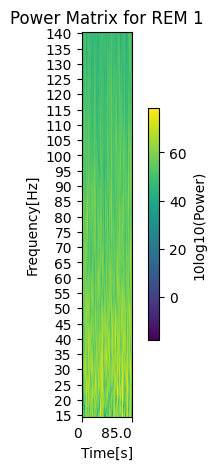

Processing file: E:\Donders\1\processed\CN\post_trial2_2017-09-28_12-21-41\post_trial2_2017-09-28_12-21-41_REM_dict.h5
Available groups: ['post_trial2_2017-09-28_12-21-41']
(157500, 6)


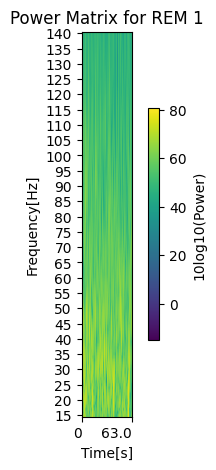

Processing file: E:\Donders\1\processed\CN\post_trial3_2017-09-28_13-12-53\post_trial3_2017-09-28_13-12-53_REM_dict.h5
Available groups: ['post_trial3_2017-09-28_13-12-53']
(52500, 6)


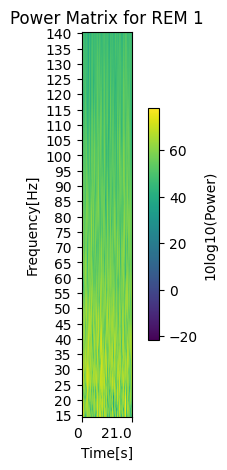

(145000, 6)


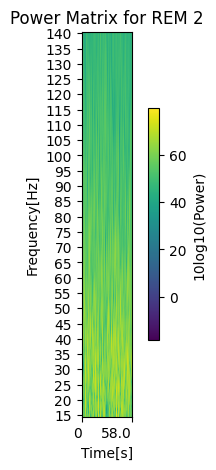

(47500, 6)


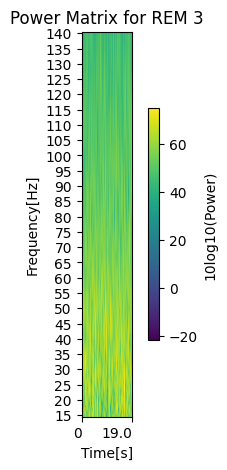

(75000, 6)


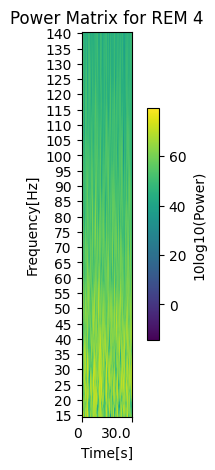

(55000, 6)


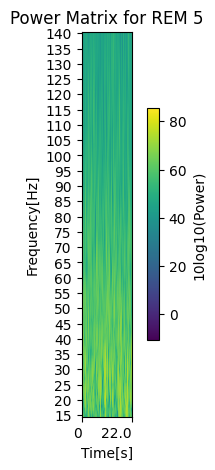

(202500, 6)


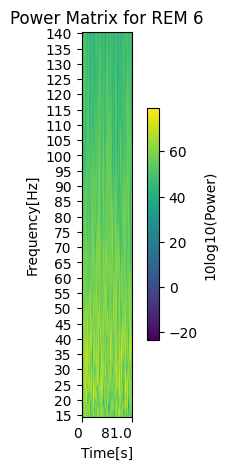

(117500, 6)


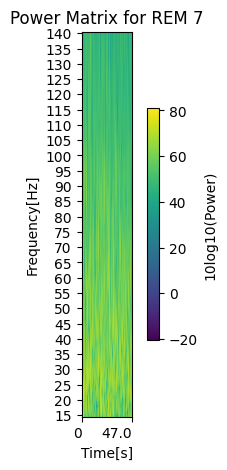

Processing file: E:\Donders\1\processed\CN\post_trial4_2017-09-28_14-03-38\post_trial4_2017-09-28_14-03-38_REM_dict.h5
Available groups: ['post_trial4_2017-09-28_14-03-38']
(275000, 6)


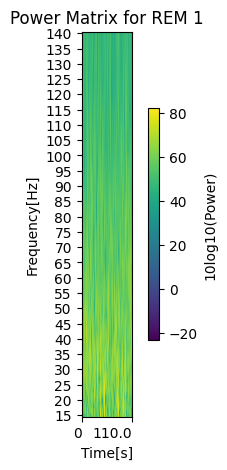

(82500, 6)


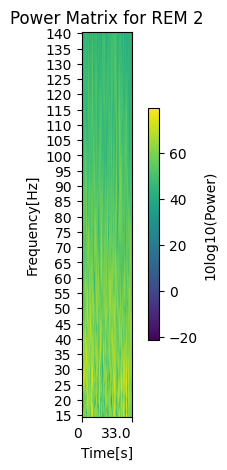

Processing file: E:\Donders\1\processed\CN\post_trial5_2017-09-28_14-55-18\post_trial5_2017-09-28_14-55-18_REM_dict.h5
Available groups: ['post_trial5_2017-09-28_14-55-18']
(230000, 6)


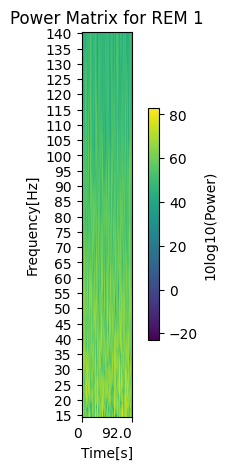

(280000, 6)


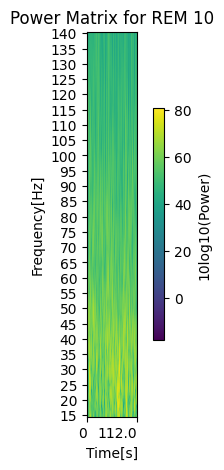

(227500, 6)


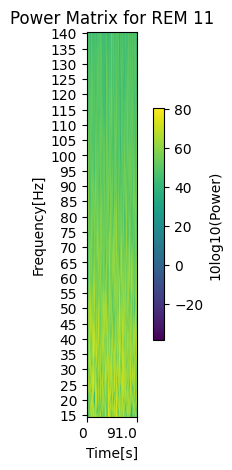

(277500, 6)


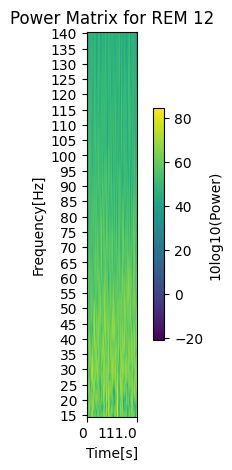

(85000, 6)


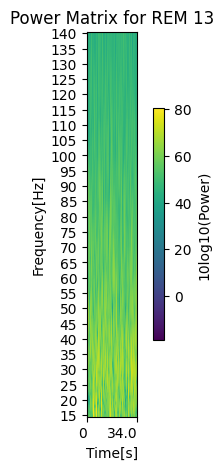

(50000, 6)


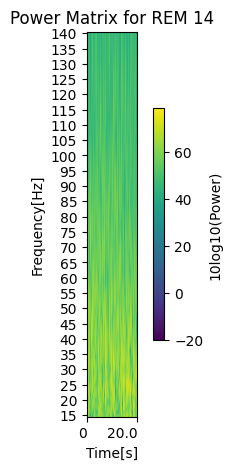

(255000, 6)


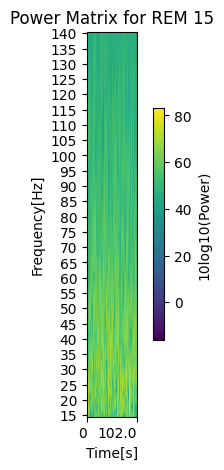

(140000, 6)


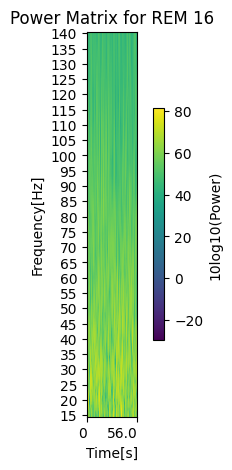

(367500, 6)


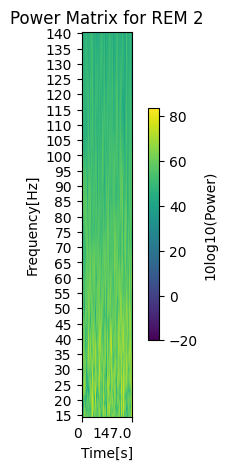

(252500, 6)


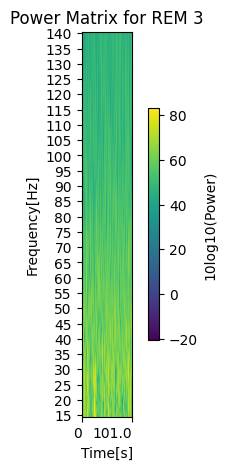

(127500, 6)


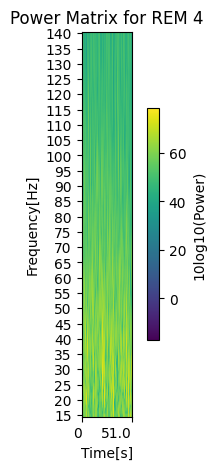

(267500, 6)


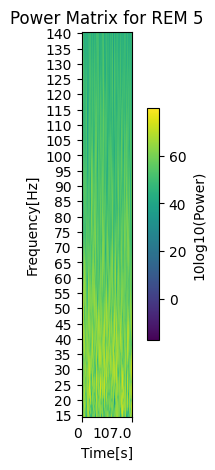

(125000, 6)


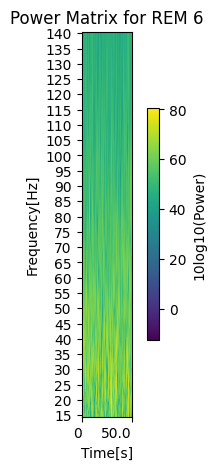

(62500, 6)


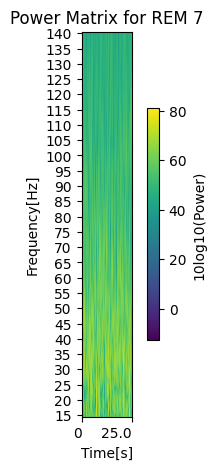

(25000, 6)


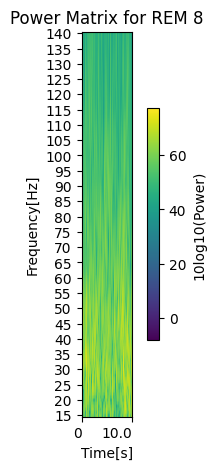

(357500, 6)


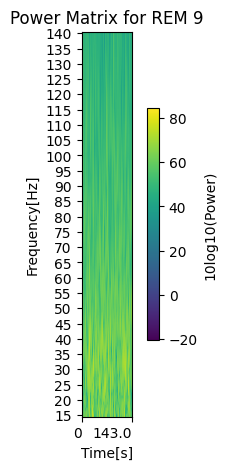

Processing file: E:\Donders\1\processed\HC\post_trial1_2017-09-27_10-56-20\post_trial1_2017-09-27_10-56-20_REM_dict.h5
Available groups: ['post_trial1_2017-09-27_10-56-20']
(175000, 6)


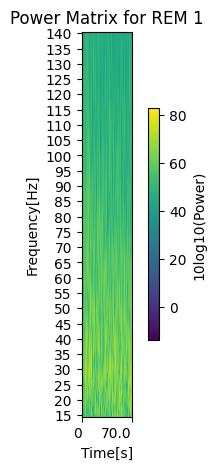

Processing file: E:\Donders\1\processed\HC\post_trial2_2017-09-27_11-46-56\post_trial2_2017-09-27_11-46-56_REM_dict.h5
Available groups: ['post_trial2_2017-09-27_11-46-56']
(162500, 6)


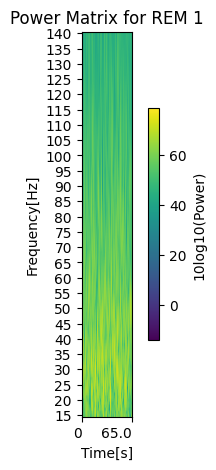

(170000, 6)


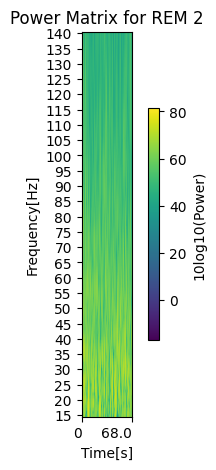

(27500, 6)


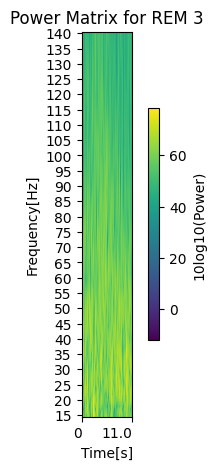

Processing file: E:\Donders\1\processed\HC\post_trial3_2017-09-27_12-37-12\post_trial3_2017-09-27_12-37-12_REM_dict.h5
Available groups: ['post_trial3_2017-09-27_12-37-12']
(87500, 6)


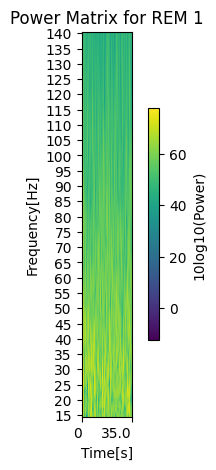

(155000, 6)


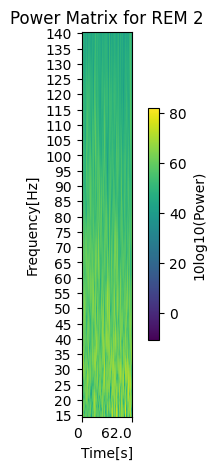

(77500, 6)


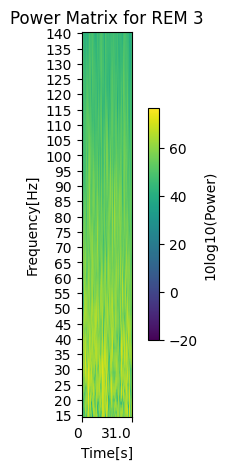

(65000, 6)


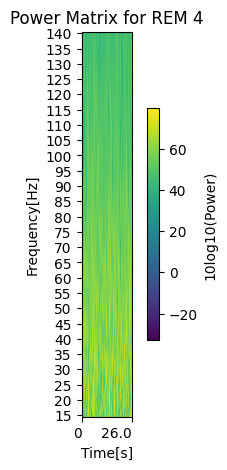

Processing file: E:\Donders\1\processed\HC\post_trial4_2017-09-27_13-27-32\post_trial4_2017-09-27_13-27-32_REM_dict.h5
Available groups: ['post_trial4_2017-09-27_13-27-32']
(182500, 6)


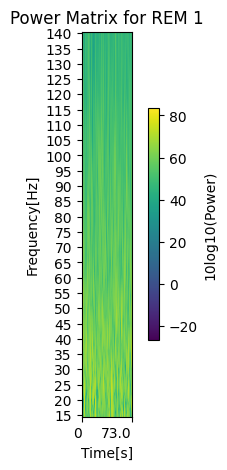

(177500, 6)


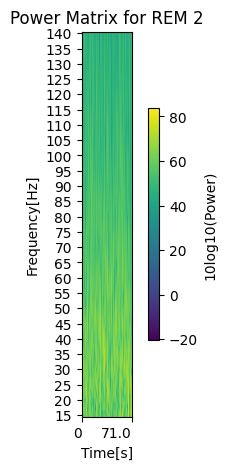

(97500, 6)


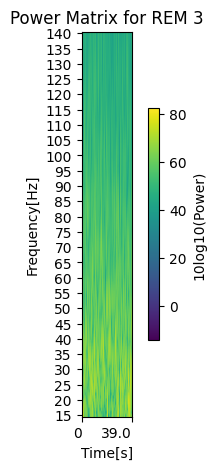

Processing file: E:\Donders\1\processed\HC\post_trial5_2017-09-27_14-18-24\post_trial5_2017-09-27_14-18-24_REM_dict.h5
Available groups: ['post_trial5_2017-09-27_14-18-24']
(335000, 6)


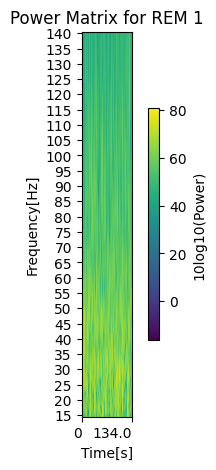

(207500, 6)


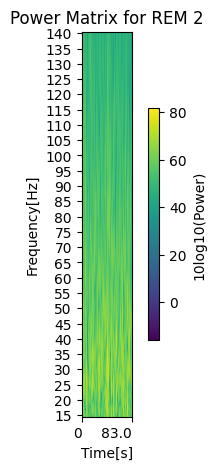

(245000, 6)


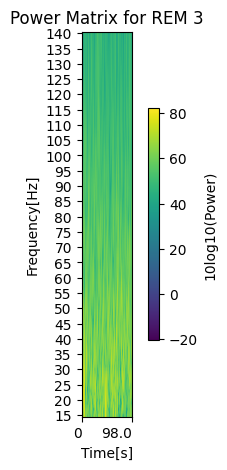

(62500, 6)


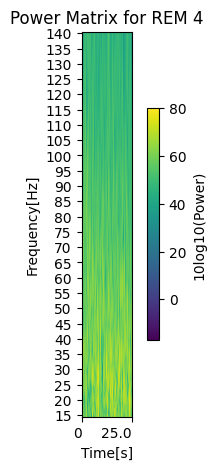

(115000, 6)


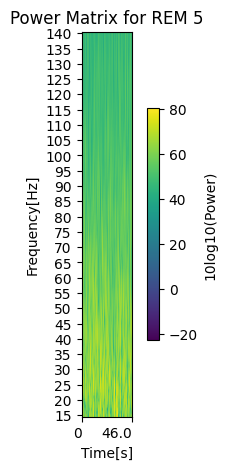

(115000, 6)


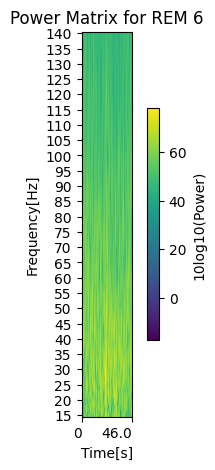

(310000, 6)


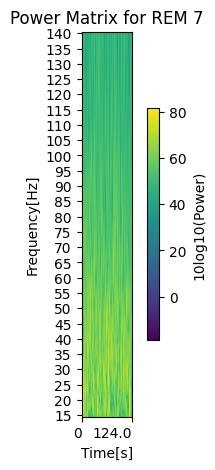

(310000, 6)


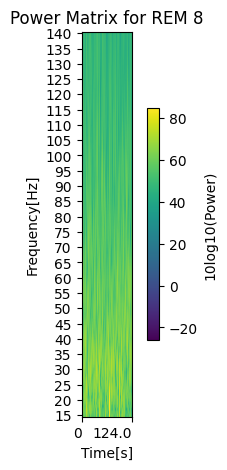

(207500, 6)


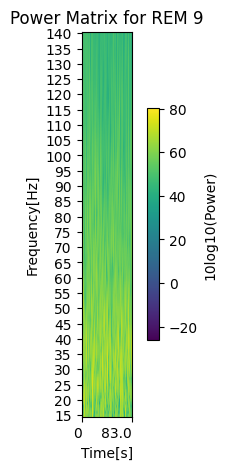

Processing file: E:\Donders\1\processed\HC\presleep_2017-09-27_10-02-30\presleep_2017-09-27_10-02-30_REM_dict.h5
Available groups: ['presleep_2017-09-27_10-02-30']
Processing file: E:\Donders\1\processed\OD\post_trial1_2017-09-21_11-06-43\post_trial1_2017-09-21_11-06-43_REM_dict.h5
Available groups: ['post_trial1_2017-09-21_11-06-43']
(285000, 6)


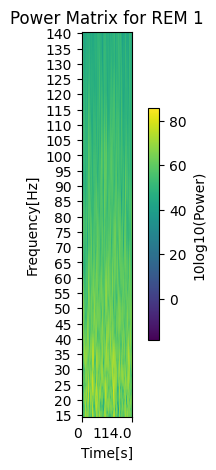

(170000, 6)


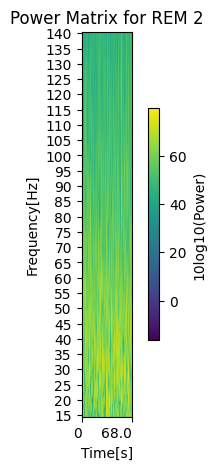

Processing file: E:\Donders\1\processed\OD\post_trial2_2017-09-21_11-57-34\post_trial2_2017-09-21_11-57-34_REM_dict.h5
Available groups: ['post_trial2_2017-09-21_11-57-34']
(270000, 6)


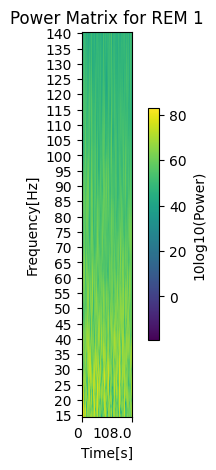

(100000, 6)


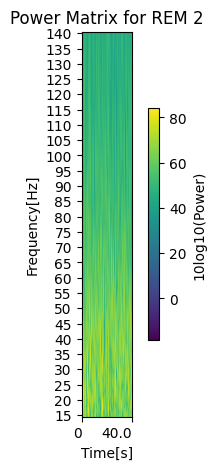

Processing file: E:\Donders\1\processed\OD\post_trial3_2017-09-21_12-48-10\post_trial3_2017-09-21_12-48-10_REM_dict.h5
Available groups: ['post_trial3_2017-09-21_12-48-10']
(277500, 6)


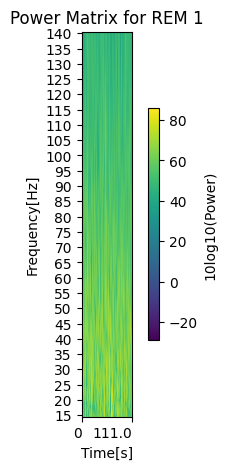

(467500, 6)


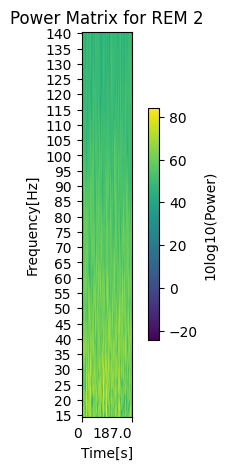

(220000, 6)


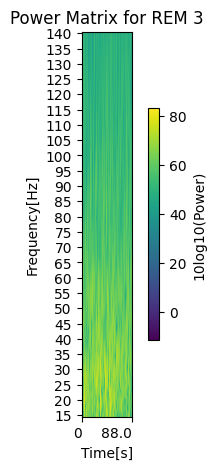

(440000, 6)


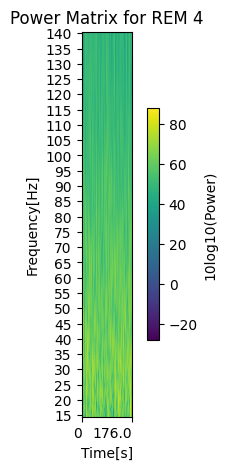

(42500, 6)


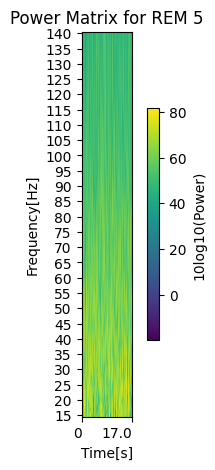

Processing file: E:\Donders\1\processed\OD\post_trial4_2017-09-21_13-40-22\post_trial4_2017-09-21_13-40-22_REM_dict.h5
Available groups: ['post_trial4_2017-09-21_13-40-22']
(465000, 6)


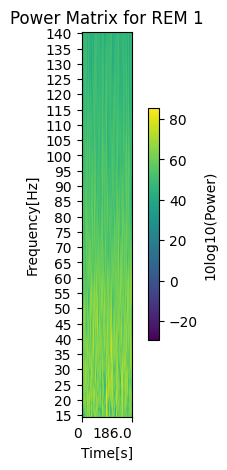

(527500, 6)


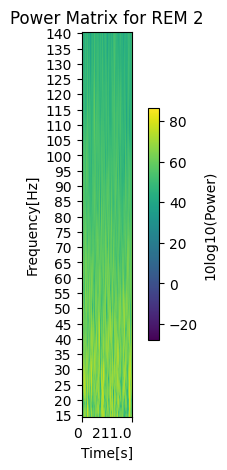

Processing file: E:\Donders\1\processed\OD\post_trial5_2017-09-21_14-31-51\post_trial5_2017-09-21_14-31-51_REM_dict.h5
Available groups: ['post_trial5_2017-09-21_14-31-51']
(602500, 6)


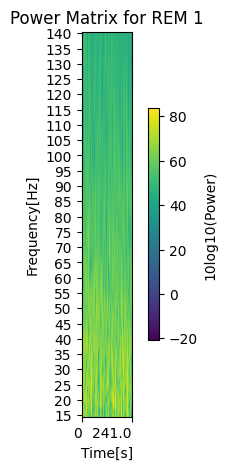

(417500, 6)


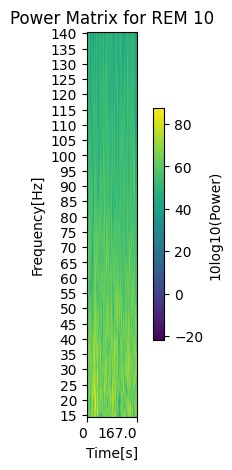

(122500, 6)


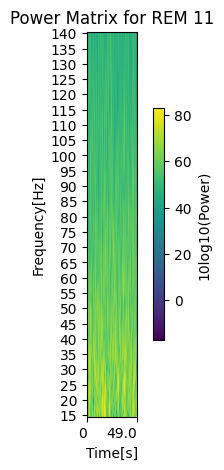

(40000, 6)


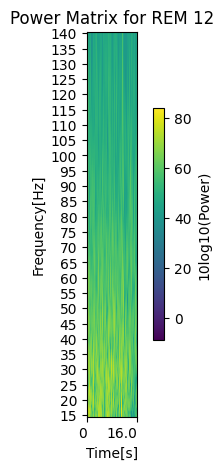

(80000, 6)


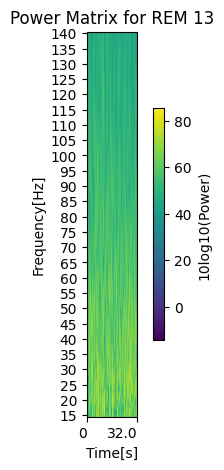

(260000, 6)


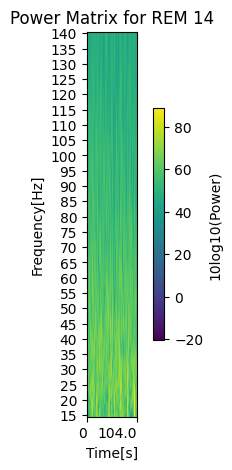

(702500, 6)


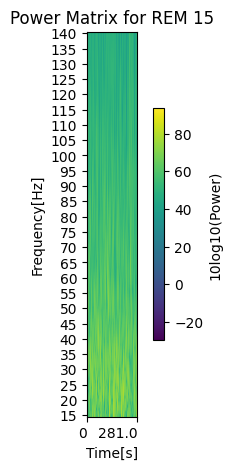

(170000, 6)


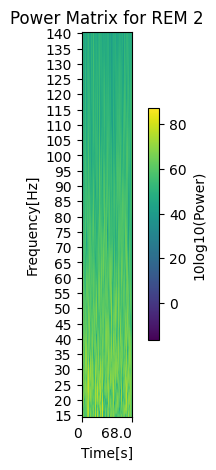

(197500, 6)


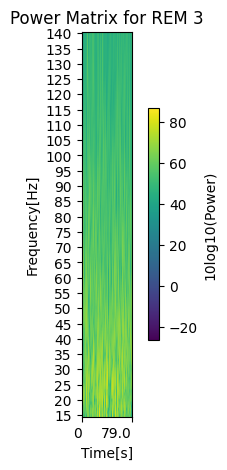

(200000, 6)


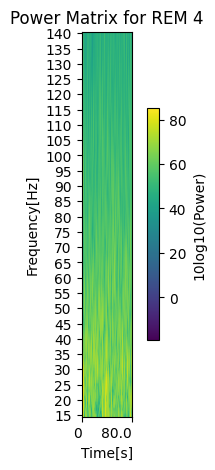

(117500, 6)


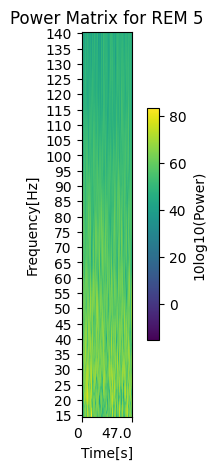

(7500, 6)


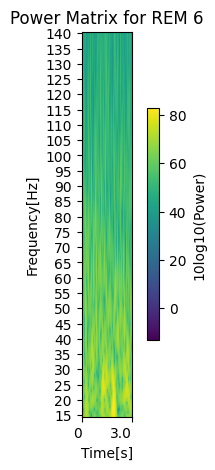

(715000, 6)


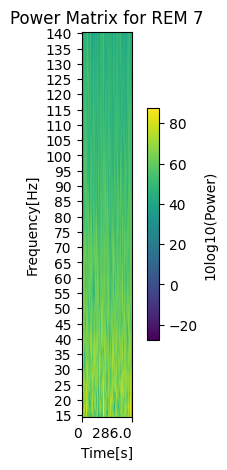

(2500, 6)


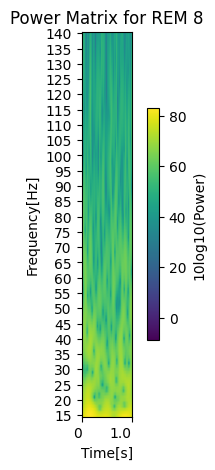

(87500, 6)


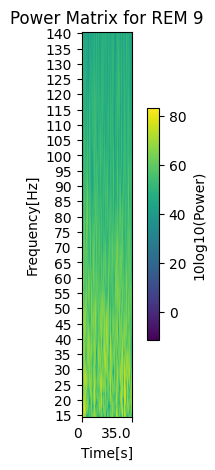

Processing file: E:\Donders\1\processed\OD\presleep_2017-09-21_10-12-40\presleep_2017-09-21_10-12-40_REM_dict.h5
Available groups: ['presleep_2017-09-21_10-12-40']
Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial1_2017-09-25_11-26-43\post_trial1_2017-09-25_11-26-43_REM_dict.h5
Available groups: ['post_trial1_2017-09-25_11-26-43']
(157500, 6)


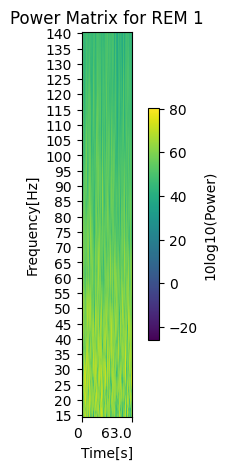

(157500, 6)


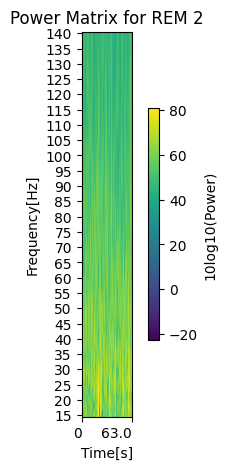

Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial2_2017-09-25_12-17-49\post_trial2_2017-09-25_12-17-49_REM_dict.h5
Available groups: ['post_trial2_2017-09-25_12-17-49']
(15000, 6)


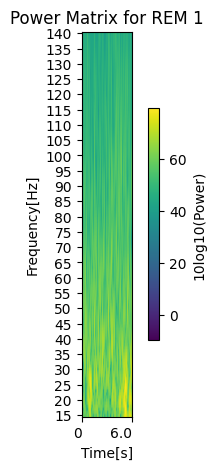

(5000, 6)


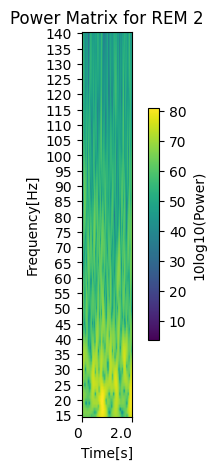

(20000, 6)


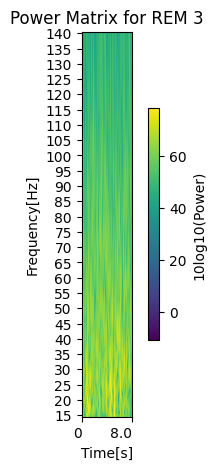

(27500, 6)


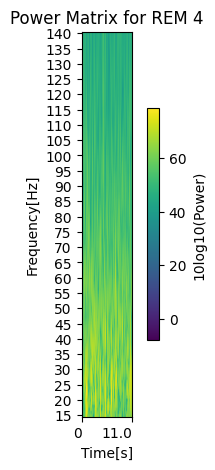

(15000, 6)


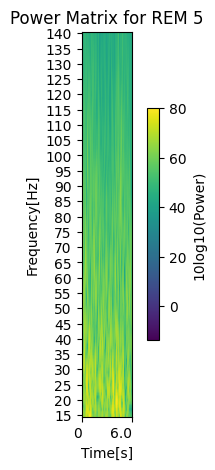

Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial3_2017-09-25_13-08-52\post_trial3_2017-09-25_13-08-52_REM_dict.h5
Available groups: ['post_trial3_2017-09-25_13-08-52']
(150000, 6)


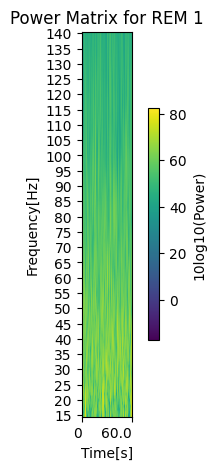

(47500, 6)


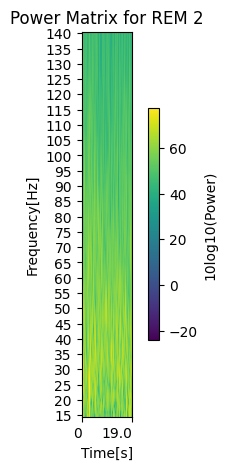

(245000, 6)


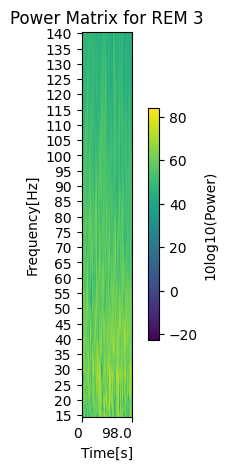

Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial4_2017-09-25_14-01-00\post_trial4_2017-09-25_14-01-00_REM_dict.h5
Available groups: ['post_trial4_2017-09-25_14-01-00']
(310000, 6)


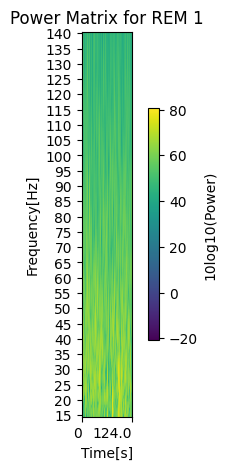

(62500, 6)


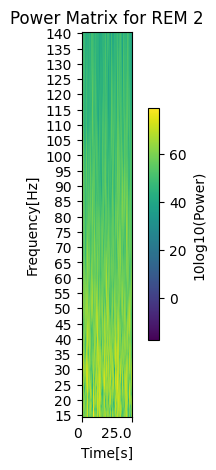

(275000, 6)


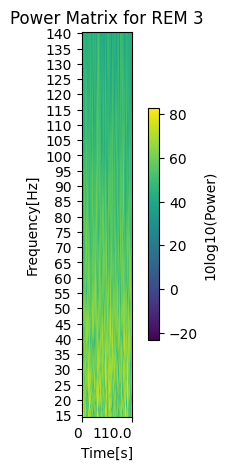

(92500, 6)


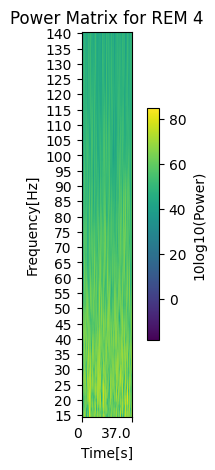

(255000, 6)


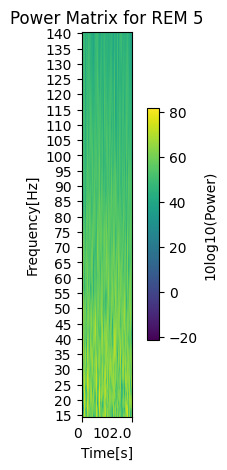

(105000, 6)


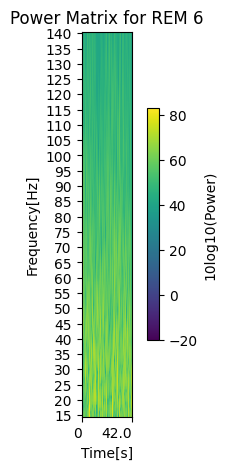

Processing file: E:\Donders\1\processed\study_day_2_OR\post_trial5_2017-09-25_14-52-04\post_trial5_2017-09-25_14-52-04_REM_dict.h5
Available groups: ['post_trial5_2017-09-25_14-52-04']
(172500, 6)


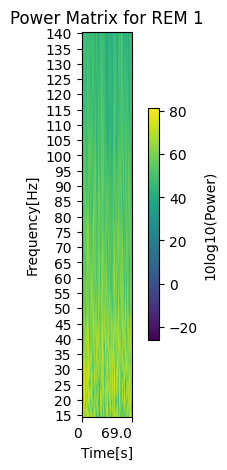

(197500, 6)


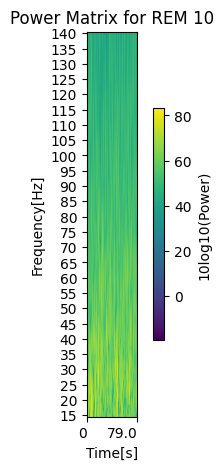

(62500, 6)


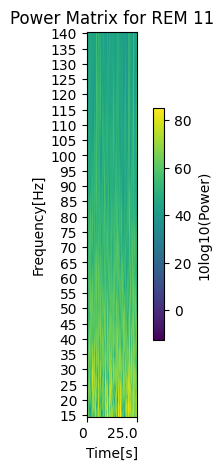

(22500, 6)


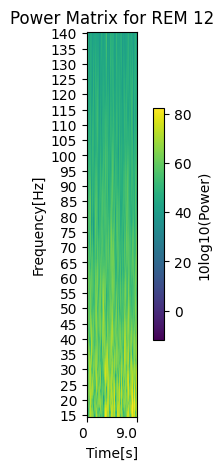

(117500, 6)


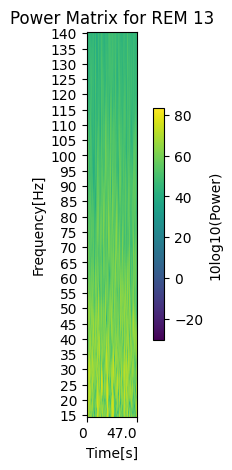

(7500, 6)


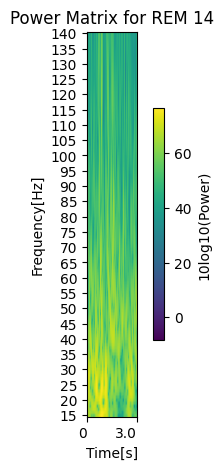

(2972500, 6)


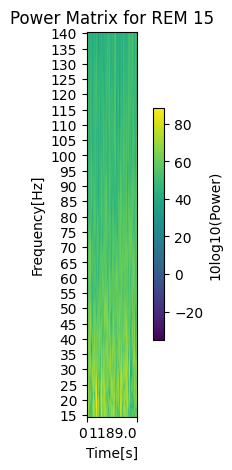

(282500, 6)


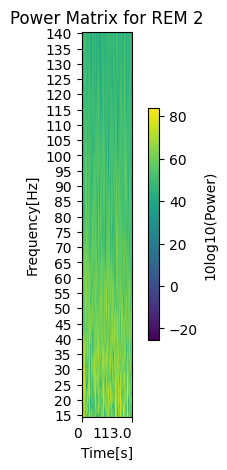

(40000, 6)


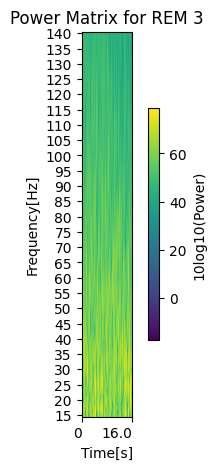

(122500, 6)


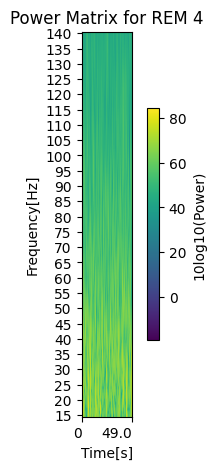

(147500, 6)


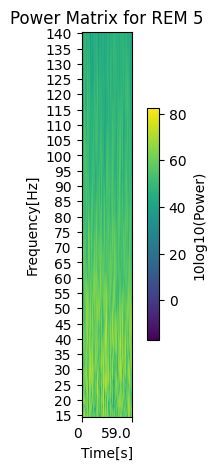

(405000, 6)


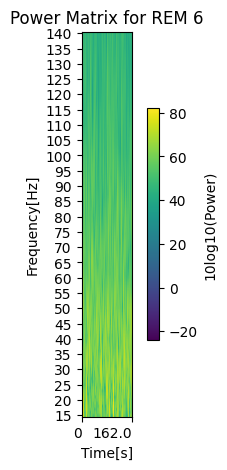

(122500, 6)


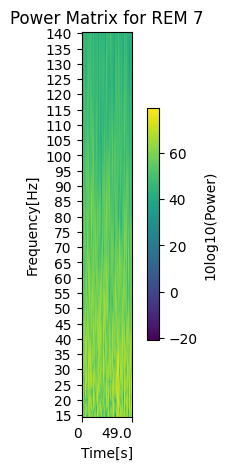

(240000, 6)


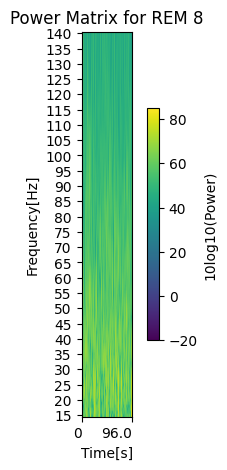

(335000, 6)


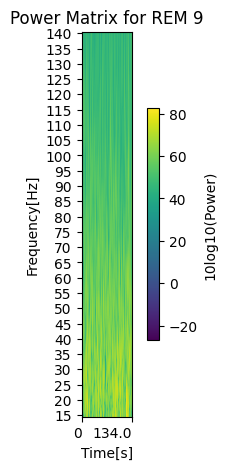

Processing file: E:\Donders\1\processed\study_day_2_OR\presleep_2017-09-25_10-30-34\presleep_2017-09-25_10-30-34_REM_dict.h5
Available groups: ['presleep_2017-09-25_10-30-34']
Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial1_2017-10-03_11-05-10\post_trial1_2017-10-03_11-05-10_REM_dict.h5
Available groups: ['post_trial1_2017-10-03_11-05-10']
Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial2_2017-10-03_12-00-20\post_trial2_2017-10-03_12-00-20_REM_dict.h5
Available groups: ['post_trial2_2017-10-03_12-00-20']
Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial3_2017-10-03_12-53-38\post_trial3_2017-10-03_12-53-38_REM_dict.h5
Available groups: ['post_trial3_2017-10-03_12-53-38']
Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial4_2017-10-03_13-45-43\post_trial4_2017-10-03_13-45-43_REM_dict.h5
Available groups: ['post_trial4_2017-10-03_13-45-43']
(150000, 6)


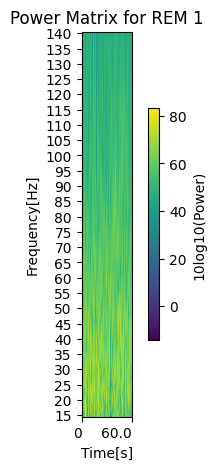

Processing file: E:\Donders\1\processed\study_day_5_OR_N\post_trial5_2017-10-03_15-12-56\post_trial5_2017-10-03_15-12-56_REM_dict.h5
Available groups: ['post_trial5_2017-10-03_15-12-56']
(50000, 6)


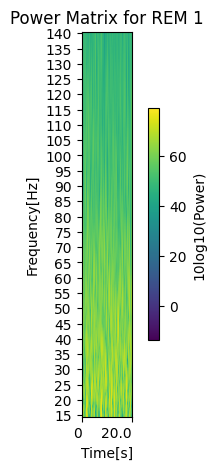

(412500, 6)


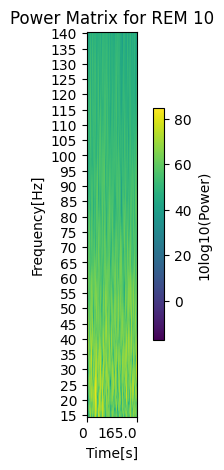

(297500, 6)


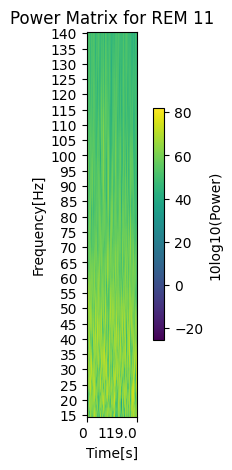

(195000, 6)


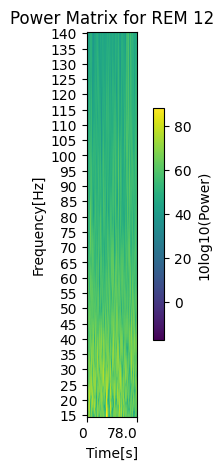

(447500, 6)


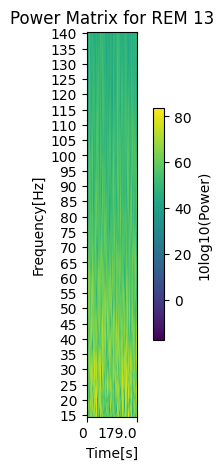

(45000, 6)


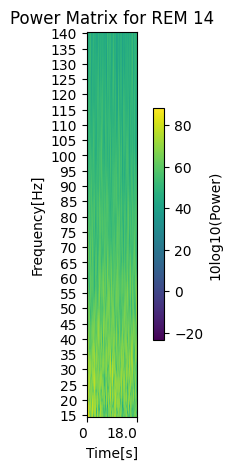

(190000, 6)


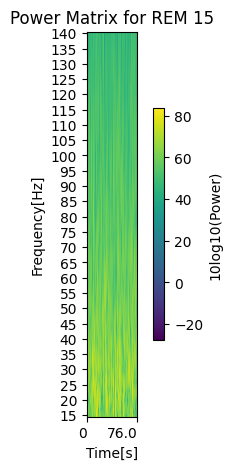

(105000, 6)


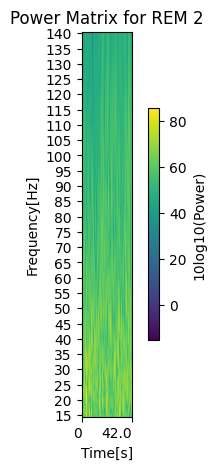

(337500, 6)


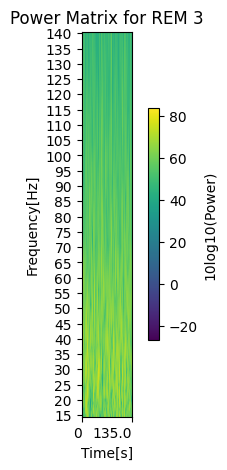

(102500, 6)


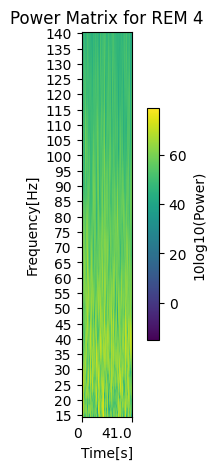

(12500, 6)


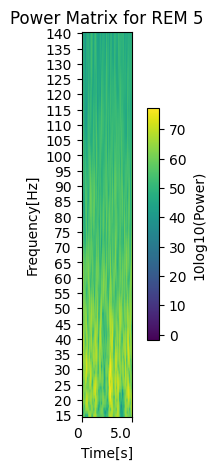

(340000, 6)


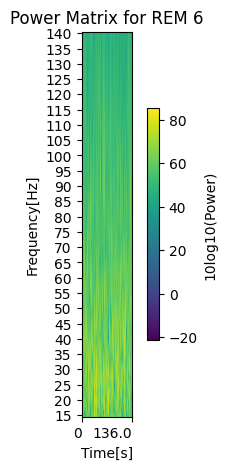

(377500, 6)


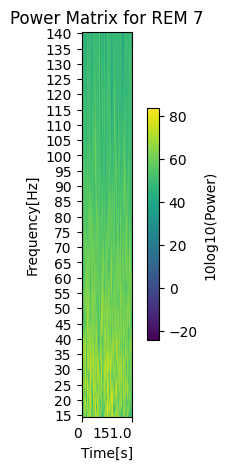

(32500, 6)


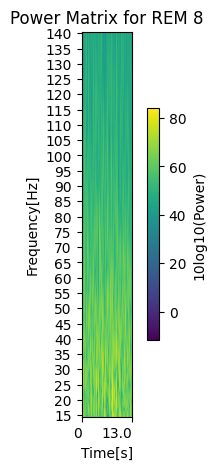

(10000, 6)


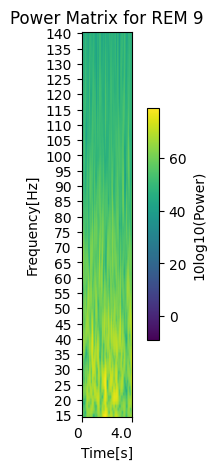

Processing file: E:\Donders\1\processed\study_day_5_OR_N\presleep_2017-10-03_10-12-30\presleep_2017-10-03_10-12-30_REM_dict.h5
Available groups: ['presleep_2017-10-03_10-12-30']


In [3]:
#This cell plots the wavelet spectra in a 10log10(power) representation for the defined rats
#The colorscale is individual for each plot
# Define the root folder containing '1', '3','4', '6', '9', '11', '13' (rat number)
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1']
frequency_array = np.arange(15, 140, 1)
power_list = []
fpp_list = []

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                # Print debugging information
                                print(f"Processing file: {hdf5_file_path}")
                                print(f"Available groups: {list(hdf_file.keys())}")
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())

                                for rem_key in rem_dict_keys:
                                    # Access the 'IMFs' key to get the Intrinsic Mode Functions
                                    imfs = current_group[rem_key]['IMFs']
                                    print(imfs.shape)
                                    # Identify the indices of theta frequencies in the 'IMFs' array
                                    theta_range = (5, 12)
                                    sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], theta_range)

                                    # Extract IMFs corresponding to theta signals and sum them up
                                    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)

                                    # Access the 'wavelet_transform' key for the current REM period
                                    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
                                    # Square each value in the matrix to get power
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                    # Calculate the 10*log10 of the power matrix
                                    log_power_matrix = 10 * np.log10(power_matrix)

                                    # ...

                                    # Plot the power matrix
                                    fig, ax = plt.subplots(figsize=(1, 5))
                                    im = plt.imshow(log_power_matrix, cmap='viridis', aspect='auto', origin='lower')

                                    cbar = plt.colorbar(im, label='10log10(Power)', aspect=20, pad=0.20)  # Adjusted pad value

                                    plt.title(f'Power Matrix for {rem_key}')
                                    plt.xlabel('Time[s]')
                                    plt.ylabel('Frequency[Hz]')
                                    
                                    # Set y-axis ticks and labels
                                    frequency_ticks = np.arange(15, 141, 5)
                                    plt.yticks(np.linspace(0, len(frequency_array) - 1, len(frequency_ticks)), frequency_ticks)

                                    # Calculate the corresponding time for each x-axis tick
                                    total_duration_seconds = log_power_matrix.shape[1] / 2500

                                    # Set x-axis ticks at approximately 10 evenly spaced intervals, rotate the labels diagonally, and format as integers
                                    plt.xticks([0, log_power_matrix.shape[1] - 1], [0, round(total_duration_seconds, 2)], ha='right')

                                    plt.show()










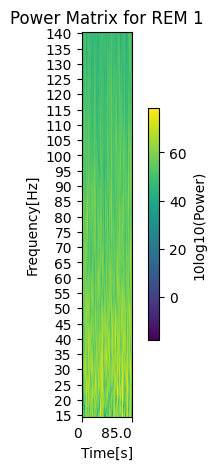

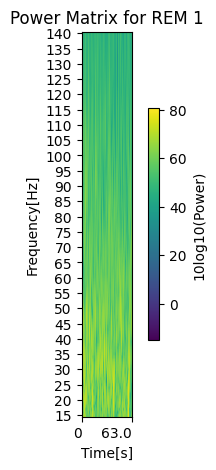

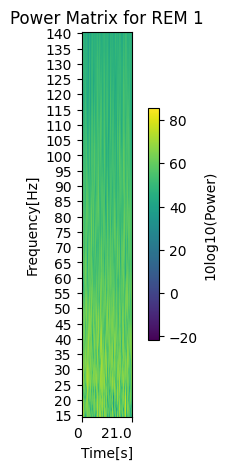

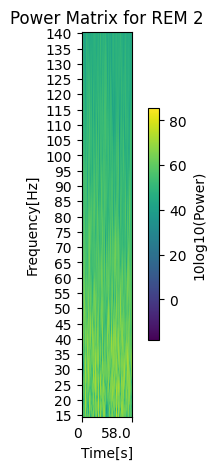

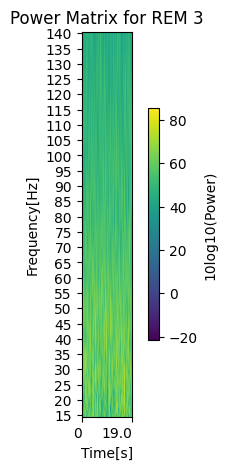

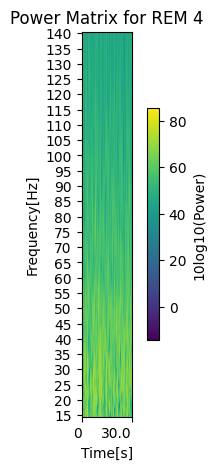

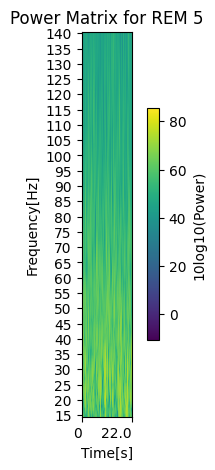

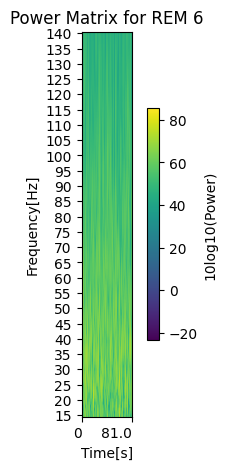

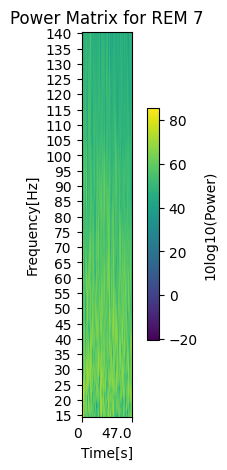

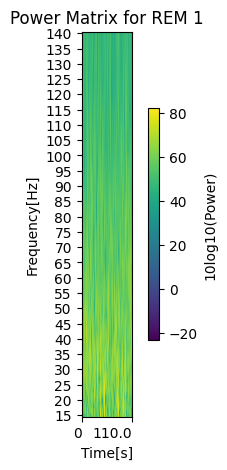

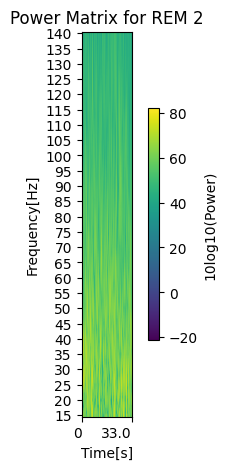

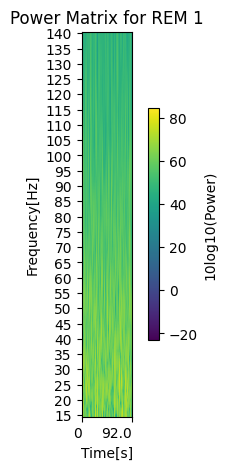

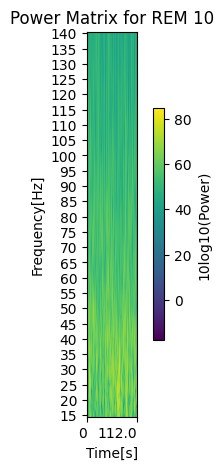

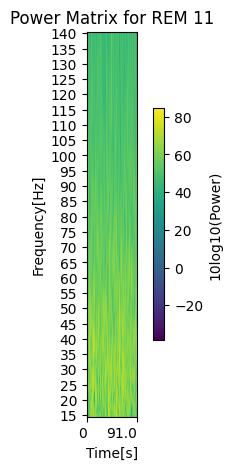

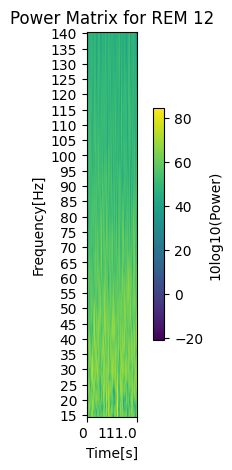

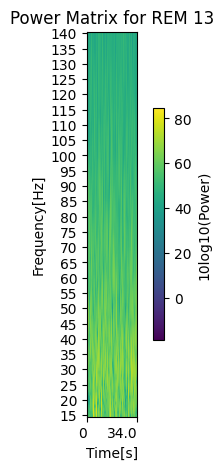

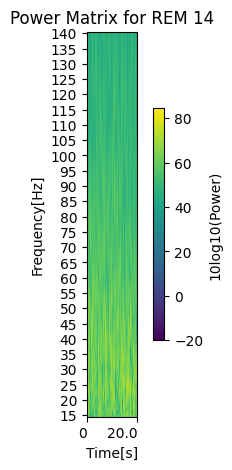

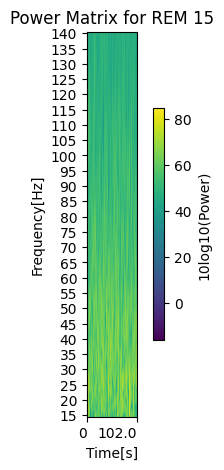

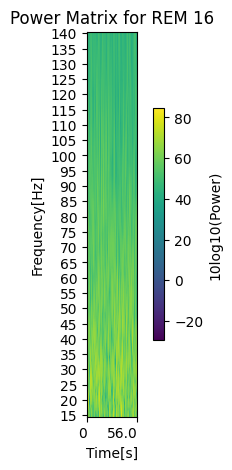

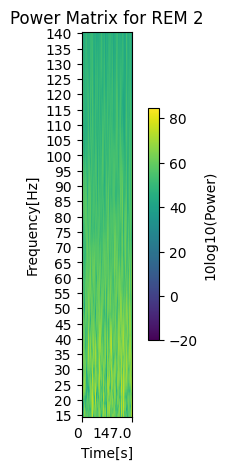

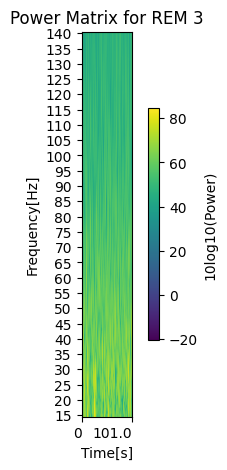

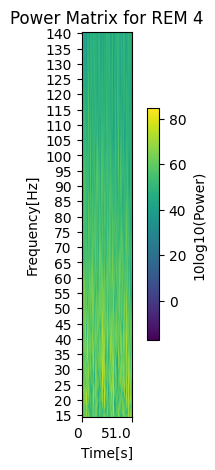

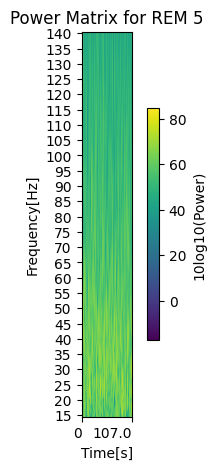

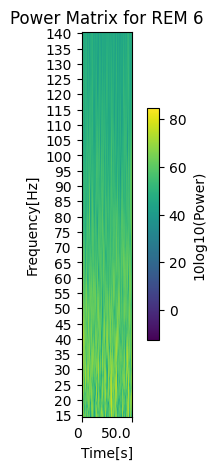

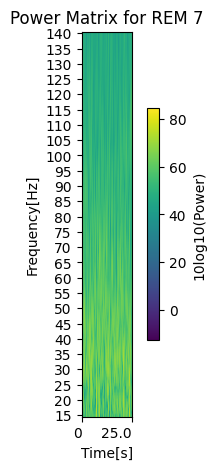

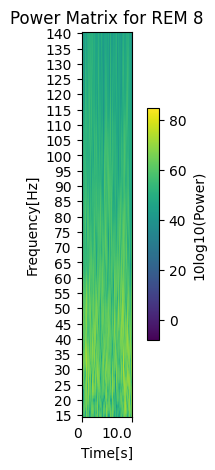

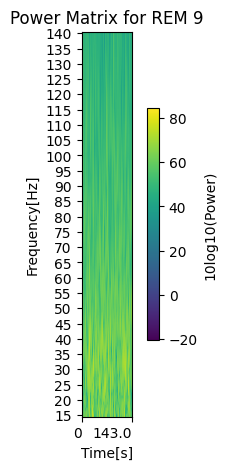

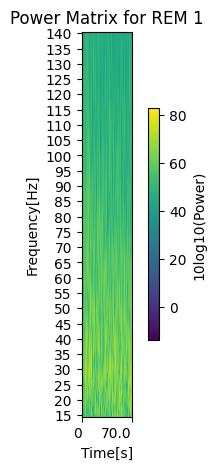

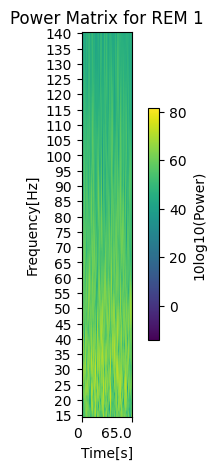

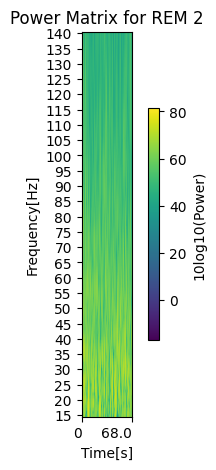

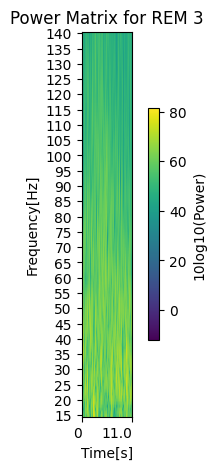

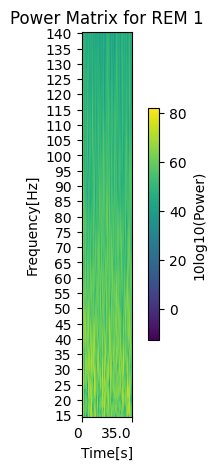

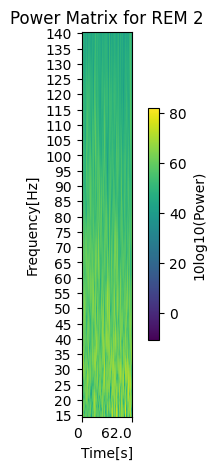

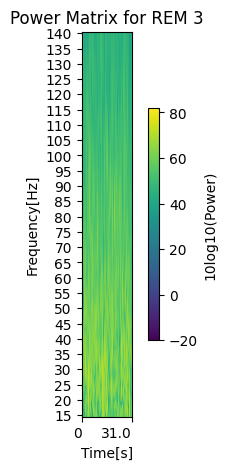

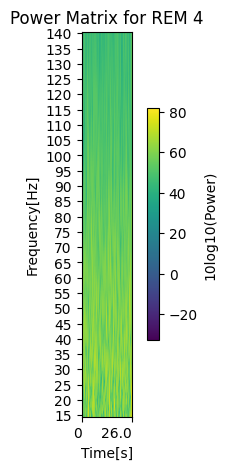

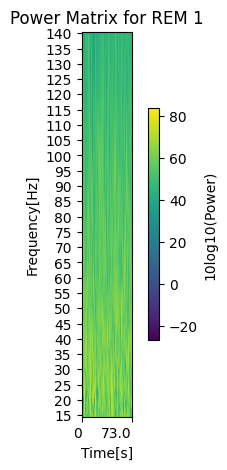

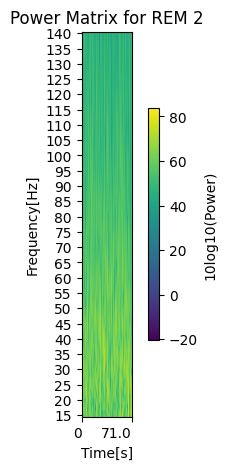

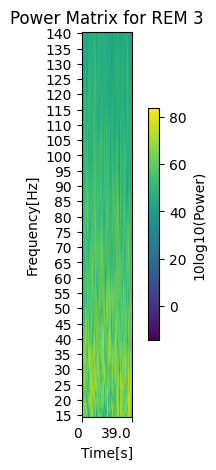

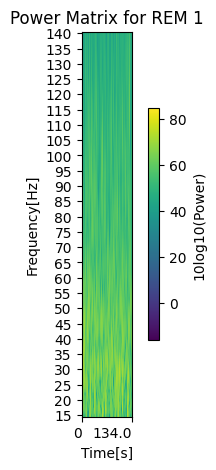

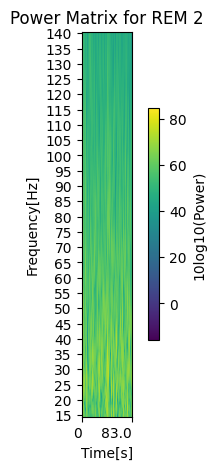

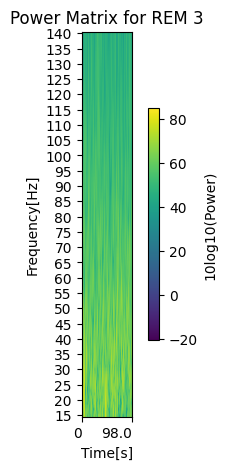

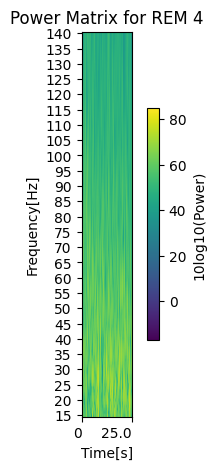

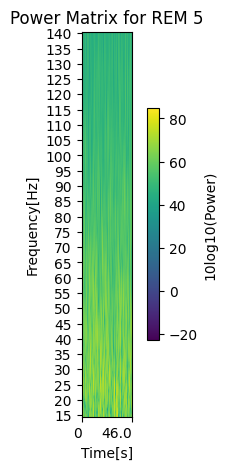

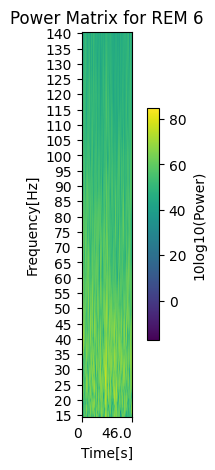

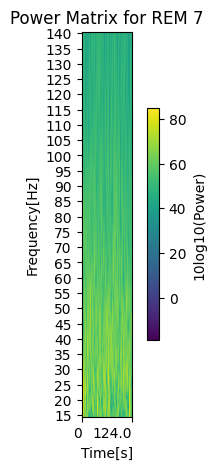

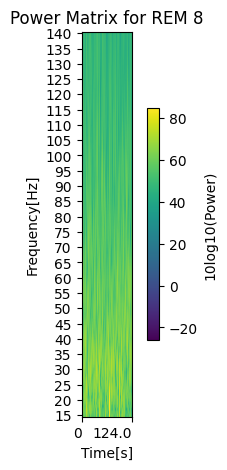

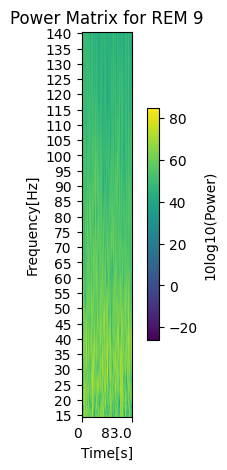

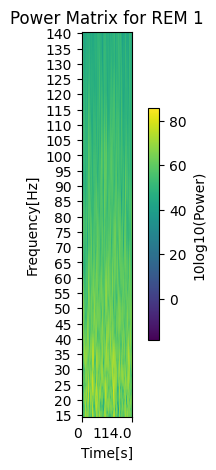

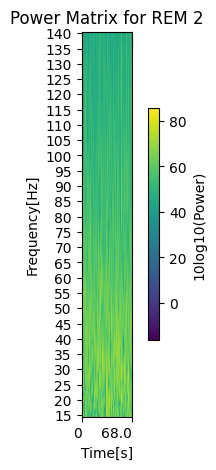

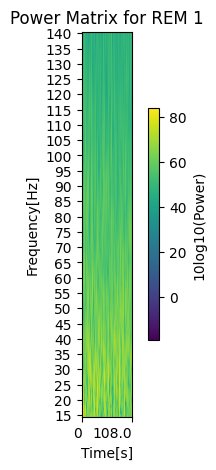

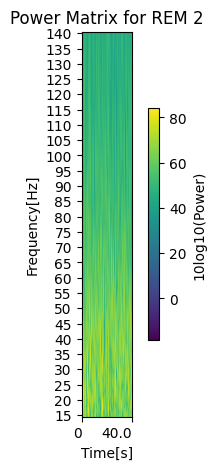

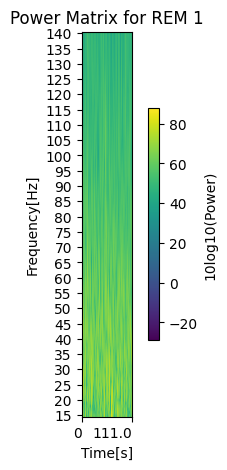

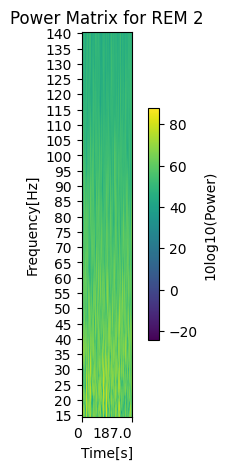

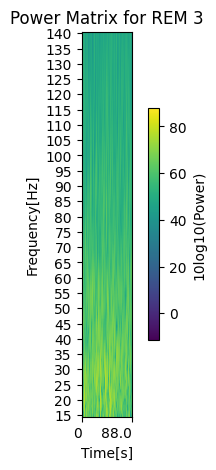

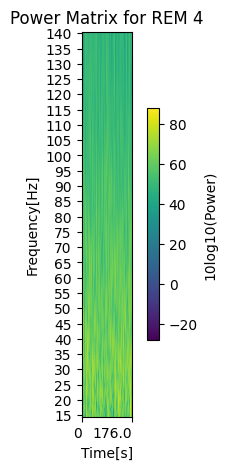

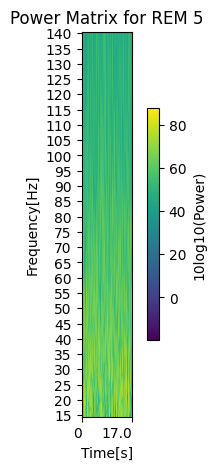

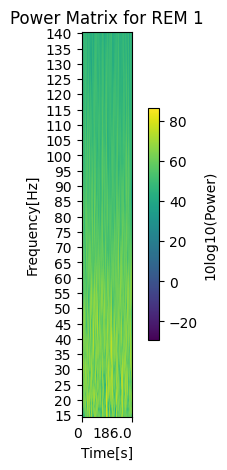

In [ ]:
#This cell plots the wavelet spectra in a 10log10(power) representation for the defined rats
#The maximum of the colorscale is the maximum 10log10(power) within one dataset (over multiple REM periods)



# Define the root folder containing '1', '3','4', '6', '9', '11', '13' folders
root_folder = r"E:\Donders"

# Define the target folders
target_folders = ['1']
frequency_array = np.arange(15, 140, 1)

for target_folder in target_folders:
    # Construct the path to the processed folders
    processed_folder = os.path.join(root_folder, target_folder, 'processed')

    # Iterate through subfolders in processed folder
    for subfolder in os.listdir(processed_folder):
        subfolder_path = os.path.join(processed_folder, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Iterate through sub-subfolders (containing datasets)
            for dataset_folder in os.listdir(subfolder_path):
                dataset_folder_path = os.path.join(subfolder_path, dataset_folder)

                # Check if it's a directory
                if os.path.isdir(dataset_folder_path):
                    # Initialize the maximum power for the current dataset
                    max_power_within_dataset = 0

                    # Use glob to get all .h5 files in the dataset folder
                    hdf5_files = glob.glob(os.path.join(dataset_folder_path, '*.h5'))

                    # Iterate over each .h5 file
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())

                                # Find the maximum power within each REM period
                                for rem_key in rem_dict_keys:
                                    imfs = current_group[rem_key]['IMFs']
                                    supra_theta_range = (5, 12)
                                    sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], supra_theta_range)
                                    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)
                                    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                     # Calculate the 10*log10 of the power matrix
                                    log_power_matrix = 10 * np.log10(power_matrix)
                                    # Update max_power_within_dataset if a higher value is found
                                    max_power_within_dataset = max(max_power_within_dataset, np.max(log_power_matrix))

                    # Iterate through sub-subfolders again to plot and normalize
                    for hdf5_file_path in hdf5_files:
                        # Open the HDF5 file in read mode
                        with h5py.File(hdf5_file_path, 'r') as hdf_file:
                            # Iterate over all groups in the file
                            for group_name in hdf_file.keys():
                                # Access the current group
                                current_group = hdf_file[group_name]

                                # Continue with your processing for the current group
                                rem_dict_keys = list(current_group.keys())

                                # Iterate through REM periods again to plot and normalize
                                for rem_key in rem_dict_keys:
                                    imfs = current_group[rem_key]['IMFs']
                                    supra_theta_range = (5, 12)
                                    sub_theta, theta, supra_theta = tg_split(current_group[rem_key]['IMF_Frequencies'], supra_theta_range)
                                    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)
                                    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
                                    power_matrix = np.square(np.abs(wavelet_transform))
                                     # Calculate the 10*log10 of the power matrix
                                    log_power_matrix = 10 * np.log10(power_matrix)
                                    # Plot the power matrix with the normalized colorbar
                                    fig, ax = plt.subplots(figsize=(1, 5))
                                    im = plt.imshow(log_power_matrix, cmap='viridis', aspect='auto', origin='lower', vmax=max_power_within_dataset)
                                
                                    cbar = plt.colorbar(im, label='10log10(Power)', aspect=20, pad=0.20)  # Adjusted pad value

                                    plt.title(f'Power Matrix for {rem_key}')
                                    plt.xlabel('Time[s]')
                                    plt.ylabel('Frequency[Hz]')
                                    
                                    # Set y-axis ticks and labels
                                    frequency_ticks = np.arange(15, 141, 5)
                                    plt.yticks(np.linspace(0, len(frequency_array) - 1, len(frequency_ticks)), frequency_ticks)

                                    # Calculate the corresponding time for each x-axis tick
                                    total_duration_seconds = log_power_matrix.shape[1] / 2500

                                    
                                    plt.xticks([0, log_power_matrix.shape[1] - 1], [0, round(total_duration_seconds, 2)], ha='right')

                                    plt.show()


In [10]:
file_path = r'E:\Donders\1\processed\CN\post_trial1_2017-09-28_11-30-59\post_trial1_2017-09-28_11-30-59_REM_dict.h5'
top_key = 'post_trial1_2017-09-28_11-30-59'
rem_key = 'REM 1'

with h5py.File(file_path, 'r') as file:
    imfs = file[top_key][rem_key]['IMFs']
    supra_theta_range = (5, 12)
    sub_theta, theta, supra_theta = tg_split(file[top_key][rem_key]['IMF_Frequencies'], supra_theta_range)
    supra_theta_imfs_sum = np.sum(imfs[:, supra_theta], axis=1)
    wavelet_transform = morlet_wt(supra_theta_imfs_sum, 2500, frequency_array, n=5, mode='amplitude')
    power_matrix = np.square(np.abs(wavelet_transform))

    # Z-score along the time axis
    #power = zscore(power_matrix, axis=0)
                                
    start_end = file[top_key][rem_key]['start-end'][:]
    fpp_cycles = file[top_key][rem_key]['Cycles'][:]
    newcycles = fpp_cycles[:, [0, -1]] - start_end[0]

    # Calculate mean power values for the subset of frequencies
    fpp_plots = 10 * np.log10(bin_tf_to_fpp(newcycles, power_matrix, 19))
    print(fpp_plots.shape)

(613, 125, 19)


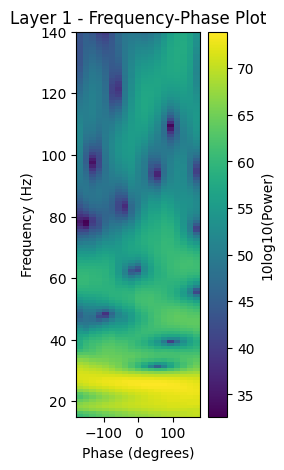

In [21]:
import matplotlib.pyplot as plt

# Select a specific layer (e.g., the first layer)
layer_index = 0
selected_layer = fpp_plots[layer_index, :, :]

# Define phase and frequency ranges
phase_range = np.linspace(-180, 180, selected_layer.shape[1])
frequency_range = np.linspace(15, 140, selected_layer.shape[0])

# Create a meshgrid for the plot
phase_grid, frequency_grid = np.meshgrid(phase_range, frequency_range)

# Plot the data
plt.figure(figsize=(2, 5))
plt.imshow(selected_layer, extent=(np.min(phase_range), np.max(phase_range), np.min(frequency_range), np.max(frequency_range)),
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='10log10(Power)')
plt.title(f'Layer {layer_index + 1} - Frequency-Phase Plot')
plt.xlabel('Phase (degrees)')
plt.ylabel('Frequency (Hz)')
plt.show()

